<center><h1>Proyecto IMT2118</h1></center>
<center><h1>Detección de blooms de algas mediante percepción remota sin mediciones in-situ.</h1></center>
<center><h2>Adolfo Parra, Diego Rodríguez</h2></center>
<center><h3>6 de Julio, 2023</h3></center>


In [1]:
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
import geemap
import pandas as pd
import geopandas as gpd
import json
from scipy.interpolate import griddata
from scipy.spatial import Voronoi, voronoi_plot_2d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from shapely.geometry import Point, Polygon
import rasterio
from rasterio.plot import show, show_hist
from osgeo import gdal
import seaborn as sns
import rioxarray
from sklearn.linear_model import LinearRegression
from pysal.model import spreg
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
import pysal as ps
from libpysal import weights
import esda
import warnings
from libpysal.weights.raster import da2WSP
from splot.esda import moran_scatterplot, plot_local_autocorrelation

warnings.filterwarnings('ignore')

/home/drodrguez/env/geo/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/home/drodrguez/env/geo/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/home/drodrguez/env/geo/lib/python3.10/site-packages/libp

In [3]:
#Importar earth engine
import ee
 
# Iniciar flujo de autentificación 
#ee.Authenticate()
 
# Inicializar la librería.
ee.Initialize()

Un pequeño disclaimer inicial: NO recomendamos ejecutar todas las celdas de este notebook.

Los sistemas de alerta temprana para blooms de algas basados en percepción remota ya han sido implementados en distintos estudios de diversos cuerpos de agua, y es un campo de estudio que está en desarrollo. Sin embargo, la mayoría de estos sistemas requieren que se tengan muestras in-situ de los niveles de chl-a (clorofila-a, un buen indicador de la presencia de algas), complicando la implementación de un sistema de alerta de este estilo.

Para la medición de chl-a se pueden ocupar distintos índices espectrales. La dificultad se encuentra en que no existe un índice que sea tranversalmente eficiente a todos los cuerpos de agua, sino que serán las características de cada cuerpo de agua las que determinen la mejor forma de estimar la concentración de chl-a mediante índices espectrales. 

Se plantea la siguiente metodología: Utilizar las mediciones de chl-a del satélite [MODIS-AQUA](https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Aqua_L3SMI) además de distintos índices espectrales (seleccionados según literatura al respecto) calculados a través de Sentinel-2, para encontrar aquellos índices espectrales con los que se observa mayor correlación con los niveles de chl-a estimados de forma remota. Luego, se pretende ajustar un modelo en base a esta información, que permita observar la dinámica y estructura de los blooms de algas. Esta metodología supone que el modelo ajustado no tiene una manera empírica de ser evaluado (pues se desconocen las muestras in-situ de chl-a). Se apelará más bien a evaluaciones visuales. De más cabe mencionar que el hecho de carecer de métodos de validación para nuestro modelo es una gran restricción, e impone sobre nuestro proyecto el carácter de exploratorio.

La idea de utilizar las mediciones del MODIS-AQUA de chl-a para estimar una buena forma de aproximar los niveles de chl-a a través de índices espectrales en vez de utilizar directamente las mediciones del satélite MODIS-AQUA es suplir 2 inconvenientes de éste último: su resolución (de aprox. 5000m vs 10-60m del Sentinel 2) y su disponibilidad temporal (diaria, pero hasta febrero del 2022).

Iniciamos definiendo nuestra área de interés. La idea de una metodología de este tipo sería aplicarla sobre un lago o cuerpo de agua de dificil acceso, donde obtener muestras de chl-a in-situ sea una complicación. Sin embargo hemos decidido trabajar con el Lago Villarrica ya que se cuenta con literatura para validar en algún nivel el proceso que se está realizando y también para orientar los esfuerzos; el método es ampliable a cualquier método de agua con el que se desee trabajar. Además, el Lago Villarrica cuenta con historial de blooms de algas bien documentados, los que nos permitirá ejercer una validación visual de los resultados de nuestro modelo.

In [4]:
'''
Definimos nuestra área de estudio.
'''

villarica = [[-39.18173270174858, -72.24787145835185],
          [-39.18173270174858, -71.95067603081017],
          [-39.32208143057435, -71.95067603081017],
          [-39.32208143057435, -72.24734914652839],
          [-39.18173270174858, -72.24787145835185]]

for sublist in villarica:
    sublist.reverse()

aoi = ee.Geometry.Polygon(villarica)

Para hacer el análisis necesario y el posterior ajuste de un modelo necesitaremos de varias mediciones. Definimos una fecha de inicio y fecha final para nuestro estudio. Consideraremos desde el 2018 en adelante, hasta el último día disponible para el satélite MODIS-AQUA.

In [5]:
fecha_inicio_0 = '2018-01-01'
fecha_final_0 = '2022-02-28'

In [6]:
# Función que retorna la colección de imágenes de MODIS
def get_modis_collection(startDate, endDate):
    modis_collection = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI')\
    .filterDate(startDate, endDate)\
    .select("chlor_a")\

    return modis_collection

# Función que retorna las fechas de toda la colección
def get_modis_dates(modis_collection):
    dates = modis_collection.aggregate_array('system:time_start').getInfo()
    dates = [pd.to_datetime(date, unit='ms') for date in dates]
    dates = [date.strftime('%Y-%m-%d') for date in dates]

    return dates

def get_sentinel2_collection(startDate, endDate, aoi):
    sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filterDate(startDate, endDate)\
    .filterBounds(aoi)

    return sentinel2_collection

In [7]:
# Obtenemos la colección de imágenes de MODIS y verificamos las fechas incluidas.

test_modis_collection = get_modis_collection(fecha_inicio_0, fecha_final_0)
test_modis_dates = get_modis_dates(test_modis_collection)

test_modis_dates

['2018-01-01',
 '2018-01-02',
 '2018-01-03',
 '2018-01-04',
 '2018-01-05',
 '2018-01-06',
 '2018-01-07',
 '2018-01-08',
 '2018-01-09',
 '2018-01-10',
 '2018-01-11',
 '2018-01-12',
 '2018-01-13',
 '2018-01-14',
 '2018-01-15',
 '2018-01-16',
 '2018-01-17',
 '2018-01-18',
 '2018-01-19',
 '2018-01-20',
 '2018-01-21',
 '2018-01-22',
 '2018-01-23',
 '2018-01-24',
 '2018-01-25',
 '2018-01-26',
 '2018-01-27',
 '2018-01-28',
 '2018-01-29',
 '2018-01-30',
 '2018-01-31',
 '2018-02-01',
 '2018-02-02',
 '2018-02-03',
 '2018-02-04',
 '2018-02-05',
 '2018-02-06',
 '2018-02-07',
 '2018-02-08',
 '2018-02-09',
 '2018-02-10',
 '2018-02-11',
 '2018-02-12',
 '2018-02-13',
 '2018-02-14',
 '2018-02-15',
 '2018-02-16',
 '2018-02-17',
 '2018-02-18',
 '2018-02-19',
 '2018-02-20',
 '2018-02-21',
 '2018-02-22',
 '2018-02-23',
 '2018-02-24',
 '2018-02-25',
 '2018-02-26',
 '2018-02-27',
 '2018-02-28',
 '2018-03-01',
 '2018-03-02',
 '2018-03-03',
 '2018-03-04',
 '2018-03-05',
 '2018-03-06',
 '2018-03-07',
 '2018-03-

In [8]:
# Obtenemos la colección de imágenes de Sentinel 2 y verificamos las fechas incluidas. 
# Filtramos para obtener sólo imagenes de excelente calidad en cuanto a presencia de nubes.

sentinel2_collection = get_sentinel2_collection(fecha_inicio_0, fecha_final_0, aoi).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 0.2)
test_sentinel_dates = get_modis_dates(sentinel2_collection)

test_sentinel_dates

['2018-12-17',
 '2018-12-17',
 '2019-01-04',
 '2019-01-14',
 '2019-01-14',
 '2019-01-19',
 '2019-01-19',
 '2019-01-26',
 '2019-01-26',
 '2019-01-31',
 '2019-01-31',
 '2019-02-13',
 '2019-02-13',
 '2019-02-15',
 '2019-02-15',
 '2019-02-25',
 '2019-02-25',
 '2019-03-20',
 '2019-03-25',
 '2019-03-25',
 '2019-03-27',
 '2019-03-27',
 '2020-01-24',
 '2020-01-24',
 '2020-02-18',
 '2020-02-18',
 '2020-02-20',
 '2020-02-20',
 '2020-03-14',
 '2020-03-26',
 '2020-03-26',
 '2020-04-08',
 '2020-04-08',
 '2020-05-25',
 '2020-05-25',
 '2020-12-04',
 '2020-12-09',
 '2020-12-31',
 '2020-12-31',
 '2021-01-08',
 '2021-01-08',
 '2021-01-18',
 '2021-01-18',
 '2021-01-20',
 '2021-01-20',
 '2021-02-04',
 '2021-02-04',
 '2021-02-09',
 '2021-02-09',
 '2021-03-04',
 '2021-03-04',
 '2021-03-21',
 '2021-03-21',
 '2021-03-29',
 '2021-05-05',
 '2021-12-09',
 '2021-12-09',
 '2021-12-16',
 '2022-02-07',
 '2022-02-07',
 '2022-02-14',
 '2022-02-14',
 '2022-02-17',
 '2022-02-17']

In [9]:
'''
Se calculan las fechas para las que existen imagenes
disponibles en ambos satélites. 
'''

fechas = set(test_modis_dates) & set(test_sentinel_dates)

fechas

{'2018-12-17',
 '2019-01-04',
 '2019-01-14',
 '2019-01-19',
 '2019-01-26',
 '2019-01-31',
 '2019-02-13',
 '2019-02-15',
 '2019-02-25',
 '2019-03-20',
 '2019-03-25',
 '2019-03-27',
 '2020-01-24',
 '2020-02-18',
 '2020-02-20',
 '2020-03-14',
 '2020-03-26',
 '2020-04-08',
 '2020-05-25',
 '2020-12-04',
 '2020-12-09',
 '2020-12-31',
 '2021-01-08',
 '2021-01-18',
 '2021-01-20',
 '2021-02-04',
 '2021-02-09',
 '2021-03-04',
 '2021-03-21',
 '2021-03-29',
 '2021-05-05',
 '2021-12-09',
 '2021-12-16',
 '2022-02-07',
 '2022-02-14',
 '2022-02-17'}

In [83]:
'''
NO RECOMENDAMOS EJECUTAR ESTA CELDA.
Se obtiene cada una de las imágenes para el satélite MODIS-AQUA.
Se almacenan localmente en disco para luego poder ser poligonizadas a través de GDAL.
'''

for fecha in fechas:
    dayOfInterest = ee.Date(fecha)
    # Obtenemos la imagen del satélite MODIS para ese día

    modisCollection = ee.ImageCollection('NASA/OCEANDATA/MODIS-Aqua/L3SMI')\
    .filterDate(dayOfInterest, dayOfInterest.advance(1, 'day'))\
    .filterBounds(aoi)\
    .select("chlor_a").first()

    geemap.ee_export_image(modisCollection, scale=4616, filename=f'MODIS/{fecha}.tif', region=aoi)  

    
    

Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/MODIS/2020-03-26.tif
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/MODIS/2021-03-04.tif
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/MODIS/2022-02-14.tif
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/MODIS/2018-12-17.tif
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/MODIS/2019-03-25.tif
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/MODIS/2021-12-09.tif
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/MODIS/2021-02-09.tif
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC

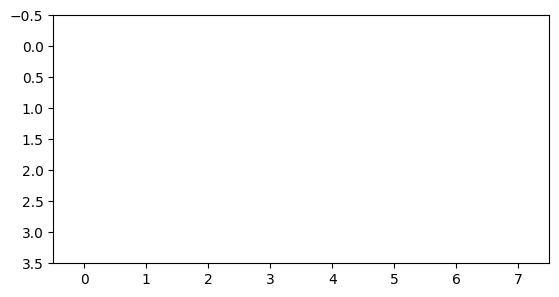

In [13]:
example = rasterio.open(f'MODIS/2018-12-17.tif').read(1)
show(example)
plt.show()

In [11]:
example

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)

Podemos ver que de repente ocurren situaciones como las que se muestran arriba, donde el raster de MODIS tiene solo valores nan. Más adelante en nuestro trabajo la información sobre estas imágenes será excluida. Veamos otro ejemplo:

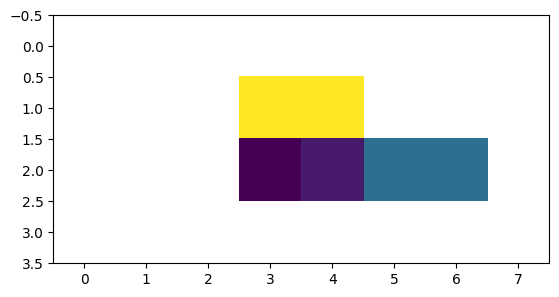

In [15]:
example = rasterio.open(f'MODIS/2021-01-20.tif')
show(example.read(1))
plt.show()

In [16]:
example.crs

CRS.from_epsg(4326)

Para la geometría del Lago Villarica, estaremos utilizando los datos del Catastro de Lagos de la Dirección General de Aguas.

In [17]:
lagos = gpd.read_file('Lagos/Inventario_Lagos.shp')
lagos = lagos[lagos['NOMBRE'] == 'LAGO VILLARRICA'].reset_index(drop=True)
lagos = lagos.to_crs(4326)


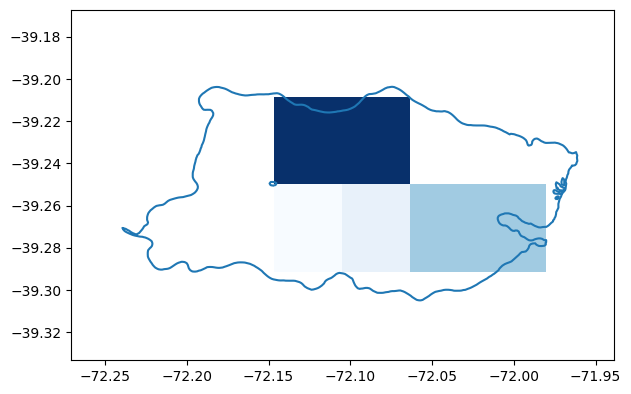

In [18]:
fig, ax = plt.subplots(1, figsize=(7,7))
 
show(example.read(1), cmap='Blues', transform=example.transform, ax=ax)
lagos.boundary.plot(ax=ax)
plt.show()


Aquí podemos observar que el lago es cubierto por unas pocas imágenes del satélite MODIS, dada la poca resolución de este. 

Para continuar con la implementación de nuestro método, necesitaremos poligonizar estos rasters; esto con el fin de poder asociar a cada uno de esos polígonos un valor tanto para el valor de la chl-a como para los distintos índices espectrales calculados. Así es como estableceremos una relación entre los índices espectrales de Sentinel 2 y las mediciones de chl-a del MODIS-AQUA.

Uno de los puntos claves a considerar en este punto es que con la poligonización a través de gdal se truncarán los valores de chl-a en cada celda del raster (por ej., de 4.5 a 4). Así funciona la poligonización por defecto en gdal. Como autores no encontramos la forma de evitar que gdal haga dicha aproximación. Se sabe que con QGIS es posible realizar una poligonización que conserve los valores. Además, una vez truncados los valores, los polígonos devueltos por gdal corresponderán en verdad a 1 polígono por valor encontrado, donde dicho polígono será la unión de los polígonos que compartían dicho valor.

In [84]:
'''
ATENCION: Es probable que esta celda no funcione en su sistema. No recomendamos ejecutar esta celda.
Poligonizamos cada una de las imágenes de MODIS.
'''

import subprocess

for fecha in fechas:
    subprocess.run(["gdal_polygonize.py", f"MODIS/{fecha}.tif", f"MODIS/{fecha}.shp"])

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...

A continuación se presentan funciones que calculan sobre una colección de imágenes distintos índices espectrales que ocuparemos para el desarrollo de nuestro método. Estos se encuentran debidamente seleccionados basados en la literatura, principalmente de 3 fuentes:

- Rodríguez-Lopez et al., 2020: De un estudio realizado sobre el estudio laja, se extrae la idea de incluir dentro de nuestro desarrollo a los índices NDVI y GNDVI.

- Bravo Herrera J., 2021: De esta memoria de título consistente en un diagnóstico del estado trófico del Lago Villarrica mediante percepción remota, se extrae la idea de incluir los índices OC2, OC4, y los índices correspondientes a la banda azul-verde (b3b1, b3b2), verde-rojo (b3b4) y rojo-nir (b5b4, b6b4, b7b4, b8ab4, b8b4).

- Markogianni, V. et al, 2018: De este trabajo enfocado en el monitoreo remoto como una herramienta para la evaluación de la calidad de agua, se extrae la idea de incluir los índices EVI, NRVI, NDWI, NDWI2, MNDWI, GNDVI, NDVI.

Disclaimer: En lo que sigue de este trabajo, existe un typo. Cada vez que se haga referencia a la métrica 'ndvi2' se refiere, en verdad, a la métrica 'ndwi2'.

In [19]:
# Enhanced vegetation index (EVI)

def calculate_evi(collection_images):
 
    evi_collection = collection_images.map(lambda image: image.expression(
        '(2.5 * (NIR - RED)) / (NIR + 6 * RED - 7.5 * BLUE + 1)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }
    ))

    return evi_collection

# Normalized Ratio Vegetation Index (NRVI)
def calculate_nrvi(collection_images):
    nrvi_collection = collection_images.map(lambda image: image.expression(
        '(RED/NIR - 1) / (RED/NIR + 1)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    ))

    return nrvi_collection

# Normalized Difference Water Index (NDWI)
def calculate_ndwi(collection_images):
    ndwi_collection = collection_images.map(lambda image: image.expression(
        '(GREEN - NIR) / (GREEN + NIR)',
        {
            'NIR': image.select('B8'),
            'GREEN': image.select('B3')
        }
    ))

    return ndwi_collection

# Normalized Difference Water Index (NDWI2)   ndvi_2 es un typo
def calculate_ndvi2(collection_images):
    ndvi2_collection = collection_images.map(lambda image: image.expression(
        '(NIR - SWIR2) / (NIR + SWIR2)',
        {
            'NIR': image.select('B8'),
            'SWIR2': image.select('B12')
        }
    ))

    return ndvi2_collection

# Modified Normalized Difference Water Index (MNDWI)
def calculate_mndwi(collection_images):
    mndwi_collection = collection_images.map(lambda image: image.expression(
        '(GREEN - SWIR2) / (GREEN + SWIR2)',
        {
            'GREEN': image.select('B3'),
            'SWIR2': image.select('B12')
        }
    ))

    return mndwi_collection

# Green Normalized Difference Vegetation Index
def calculate_gndvi(collection_images):
    gndvi_collection = collection_images.map(lambda image: image.expression(
        '(NIR - GREEN) / (NIR + GREEN)',
        {
            'NIR': image.select('B8'),
            'GREEN': image.select('B3')
        }
    ))

    return gndvi_collection

# Normalized Difference Vegetation Index
def calculate_ndvi(collection_images):
    ndvi_collection = collection_images.map(lambda image: image.expression(
        '(NIR - RED) / (NIR + RED)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    ))

    return ndvi_collection

# Indices de bandas

def calculate_b3b1(collection_images):
    b3b1_collection = collection_images.map(lambda image: image.expression(
        'GREEN / AEROSOLS',
        {
            'GREEN': image.select('B3'),
            'AEROSOLS': image.select('B1')
        }
    ))

    return b3b1_collection


def calculate_b3b2(collection_images):
    b3b2_collection = collection_images.map(lambda image: image.expression(
        'GREEN / BLUE',
        {
            'GREEN': image.select('B3'),
            'BLUE': image.select('B2')
        }
    ))

    return b3b2_collection

def calculate_b3b4(collection_images):
    b3b4_collection = collection_images.map(lambda image: image.expression(
        'GREEN / RED',
        {
            'GREEN': image.select('B3'),
            'RED': image.select('B4')
        }
    ))

    return b3b4_collection

def calculate_b5b4(collection_images):
    b5b4_collection = collection_images.map(lambda image: image.expression(
        'RED_EDGE_1 / RED',
        {
            'RED_EDGE_1': image.select('B5'),
            'RED': image.select('B4')
        }
    ))

    return b5b4_collection

def calculate_b6b4(collection_images):
    b6b4_collection = collection_images.map(lambda image: image.expression(
        'RED_EDGE_2 / RED',
        {
            'RED_EDGE_2': image.select('B6'),
            'RED': image.select('B4')
        }
    ))

    return b6b4_collection

def calculate_b7b4(collection_images):
    b7b4_collection = collection_images.map(lambda image: image.expression(
        'RED_EDGE_3 / RED',
        {
            'RED_EDGE_3': image.select('B7'),
            'RED': image.select('B4')
        }
    ))

    return b7b4_collection

def calculate_b8ab4(collection_images):
    b8ab4_collection = collection_images.map(lambda image: image.expression(
        'NIR / RED',
        {
            'NIR': image.select('B8A'),
            'RED': image.select('B4')
        }
    ))

    return b8ab4_collection

def calculate_b8b4(collection_images):
    b8b4_collection = collection_images.map(lambda image: image.expression(
        'NIR / RED',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    ))

    return b8b4_collection

def calculate_oc2(collection_images):
    oc2_collection = collection_images.map(lambda image: image.expression(
        '10 ** (0.319 - 2.336 * R_2 + 0.879 * (R_2**2) - 0.135 * (R_2**3)) - 0.071',
        {
            'R_2': ee.Image(image.select('B2')).divide(image.select('B3')).log10()
        }
    ))
    
    return oc2_collection

def calculate_oc4(collection_images):
    oc4_collection = collection_images.map(lambda image: image.expression(
        '10 ** (0.366 - 3.067 * R_4 + 1.930 * (R_4**2) + 0.649 * (R_4**3) - 1.532 * (R_4**4))',
        {
            'R_4': image.select(['B1', 'B2']).reduce(ee.Reducer.max()).divide(image.select('B3')).log10()
        }
    ))
    
    return oc4_collection

Ahora tenemos las componentes principales para poder iniciar con nuestro método. A continuación se realiza la primera fase: Para cada imagen poligonizada, y para cada uno de sus polígonos, necesitamos obtener las estadísticas zonales de los índices espectrales, es decir, asociar a cada uno de esos polígonos un valor para el índice espectral; en este caso, tomaremos la media del raster de índice clipeado para cada polígono. 

Así, al final de este proceso, tendremos una estructura tabular por imagen que contendrá para cada uno de sus polígonos el valor del chl-a observado y los respectivos índices. Estas tablas serán unidas para obtener los resultados finales.

In [91]:
'''
NO recomendamos correr esta celda. Su ejecución puede tardar más de 1 hora.
En el archivo 'indices.csv' se encuentra el resultado de éstos cómputos.
'''

result_dict = {fecha: '' for fecha in fechas}
count = 0
for fecha in fechas:
    print(fecha)    
    print(f'{len(fechas) - count} days remaining.')
    count+=1
    dayOfInterest = ee.Date(fecha)

    modis = gpd.read_file(f'MODIS/{fecha}.shp')
    
    sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR')\
    .filterDate(dayOfInterest, dayOfInterest.advance(1, 'day'))\
    .filterBounds(aoi)

    evi = calculate_evi(sentinel2_collection).first()
    nrvi = calculate_nrvi(sentinel2_collection).first()
    ndwi = calculate_ndwi(sentinel2_collection).first()
    gndvi = calculate_gndvi(sentinel2_collection).first()
    mndwi = calculate_mndwi(sentinel2_collection).first() # 20m
    ndvi2 = calculate_ndvi2(sentinel2_collection).first() # 20m
    ndvi = calculate_ndvi(sentinel2_collection).first()
    b3b1 = calculate_b3b1(sentinel2_collection).first() # 60m
    b3b2 = calculate_b3b2(sentinel2_collection).first()
    b3b4 = calculate_b3b4(sentinel2_collection).first()
    b5b4 = calculate_b5b4(sentinel2_collection).first() # 20m.
    b6b4 = calculate_b6b4(sentinel2_collection).first() # 20m. 
    b7b4 = calculate_b7b4(sentinel2_collection).first() # 20m.
    b8ab4 = calculate_b8ab4(sentinel2_collection).first() # 20m.
    b8b4 = calculate_b8b4(sentinel2_collection).first()
    oc2 = calculate_oc2(sentinel2_collection).first()
    oc4 = calculate_oc4(sentinel2_collection).first()

    m_20 = {'mndwi': mndwi, 'ndvi2':ndvi2, 'b5b4': b5b4, 'b6b4': b6b4,
            'b7b4': b7b4, 'b8ab4': b8ab4, 'b8b4': b8b4}
    
    m_10 = {'evi': evi, 'nrvi': nrvi, 'ndwi': ndwi, 'gndvi': gndvi,
            'ndvi':ndvi, 'b3b2': b3b2, 'b3b4': b3b4, 'b8b4': b8b4,
           'oc2': oc2}

    m_60 = {'b3b1': b3b1, 'oc4': oc4}
    

    for metric in m_20.keys():
        print(f'Calculating {metric}')        
        geemap.ee_export_image(m_20[metric], filename='temp.tif', scale=20,region=aoi)
        temp = rioxarray.open_rasterio('temp.tif')
        temp = temp.rio.reproject("EPSG: 4326")
        clip = temp.rio.clip([lagos.iloc[0,:].geometry])
        metrics = []
        for i in modis.index:
            local_clip = clip.rio.clip([modis.iloc[i,:].geometry])
            metrics.append(local_clip.values.mean())
        to_append = pd.Series(metrics)
        modis[metric] = metrics
        temp.close()
        
    for metric in m_10.keys():
        print(f'Calculating {metric}')
        geemap.ee_export_image(m_10[metric], filename='temp.tif', scale=10,region=aoi)
        temp = rioxarray.open_rasterio('temp.tif')
        temp = temp.rio.reproject("EPSG: 4326")
        clip = temp.rio.clip([lagos.iloc[0,:].geometry])
        metrics = []
        for i in modis.index:
            local_clip = clip.rio.clip([modis.iloc[i,:].geometry])
            metrics.append(local_clip.values.mean())
        to_append = pd.Series(metrics)
        modis[metric] = metrics
        temp.close()
        
    for metric in m_60.keys():
        print(f'Calculating {metric}')        
        geemap.ee_export_image(m_60[metric], filename='temp.tif', scale=60,region=aoi)
        temp = rioxarray.open_rasterio('temp.tif')
        temp = temp.rio.reproject("EPSG: 4326")
        clip = temp.rio.clip([lagos.iloc[0,:].geometry])
        metrics = []
        for i in modis.index:
            local_clip = clip.rio.clip([modis.iloc[i,:].geometry])
            metrics.append(local_clip.values.mean())
        to_append = pd.Series(metrics)
        modis[metric] = metrics
        temp.close()
        
    modis['Fecha'] = fecha
    result_dict[fecha] = modis   
    

2020-03-26
36 days remaining.
Calculating mndwi
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/temp.tif
Calculating ndvi2
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/temp.tif
Calculating b5b4
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/temp.tif
Calculating b6b4
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/temp.tif
Calculating b7b4
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/temp.tif
Calculating b8ab4
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/temp.tif
Calculating b8b4
Generating URL ...
Please wait ...
Data downloaded to /home/drodrguez/Documentos/UC/5to Semestre/CDG/Proyecto/temp.tif
Calculating evi

In [93]:
'''
NO ejecutar esta celda si no fue ejecutada la celda anterior.
De lo contrario, tirará error.
'''
final = pd.DataFrame([], columns=result_dict[result_dict.keys()[0])].columns)

for date in result_dict.keys():
    final = pd.concat([final, result_dict[date]])

In [28]:
final.to_csv('indices.csv', index=False)

NameError: name 'final' is not defined

In [20]:
final = pd.read_csv('indices.csv')

In [21]:
final.head()

,DN,geometry,mndwi,ndvi2,b5b4,b6b4,b7b4,b8ab4,b8b4,evi,nrvi,ndwi,gndvi,ndvi,b3b2,b3b4,oc2,b3b1,oc4,Fecha
0,-2147483648,POLYGON ((-72.27072532814142 -39.1673173990913...,0.194113,0.078714,0.166253,0.251218,0.404457,0.370025,0.478084,0.025570,-0.007183,0.153753,-0.153753,0.007183,0.240390,2.048429,8057.303510,1.028374,0.731792,2020-03-26
1,6,POLYGON ((-72.14632662759655 -39.2087836326063...,0.771170,0.352874,0.433791,0.582244,1.206311,1.029255,1.620836,0.024527,0.013162,0.646769,-0.646769,-0.013162,0.826720,9.414924,2921.403115,3.753858,1.908450,2020-03-26
2,22,POLYGON ((-72.14632662759655 -39.2502498661213...,0.852703,0.508047,0.576054,0.740371,1.302767,1.103549,1.426021,-0.012232,-0.096074,0.633432,-0.633432,0.096074,0.854009,6.329049,1.422513,2.000425,1.450958,2020-03-26
3,20,"POLYGON ((-72.1048603940816 -39.2502498661213,...",0.885308,0.540963,0.558651,0.634060,1.175653,0.962883,1.300844,-0.002857,-0.013207,0.692298,-0.692298,0.013207,0.926152,6.803384,1.721064,2.171941,1.844967,2020-03-26
4,7,POLYGON ((-72.06339416056665 -39.2502498661213...,0.773052,0.436280,0.449031,0.474497,0.900976,0.750023,0.993612,0.003633,0.029147,0.632475,-0.632475,-0.029147,0.854031,6.262982,1.722198,2.287112,1.921990,2020-03-26


In [22]:
final['DN'].value_counts()

-2147483648    36
 6              4
 7              4
 20             3
 4              3
 5              3
 22             2
 8              2
 2              1
 3              1
 11             1
 50             1
 15             1
 17             1
Name: DN, dtype: int64

Podemos ver que la mayoría de nuestros datos son nulos. Esto debido a lo que observamos de las imágenes nulas del satélite MODIS-AQUA. Simplemente eliminaremos estas mediciones.

In [23]:
filtered = final[(final['DN'] >= 0)]

Veamos que por la falta de una estructura bien definida para la forma y ubicación de los polígonos de estos datos (por las variaciones en la poligonización) no tiene mucho sentido que mantengamos la componente espacial de nuestros datos. Eliminaremos entonces la columna de geometría.

In [24]:
filtered = filtered.drop(columns=['geometry'])

In [25]:
filtered['DN'] = filtered['DN'].astype(float)

In [26]:
filtered['Fecha'] = pd.to_datetime(filtered['Fecha'])

In [27]:
filtered.sort_values('Fecha').head()

,DN,mndwi,ndvi2,b5b4,b6b4,b7b4,b8ab4,b8b4,evi,nrvi,ndwi,gndvi,ndvi,b3b2,b3b4,oc2,b3b1,oc4,Fecha
20,50.0,0.640956,0.240128,1.070406,1.145820,1.301421,1.171650,1.124927,-0.012467,-0.047225,0.476937,-0.476937,0.047225,0.884411,3.198219,1.524411,0.808377,1.262401,2019-01-26
60,20.0,0.498381,0.238181,0.833238,0.827699,0.868591,0.758379,0.800770,0.027535,0.041519,0.310994,-0.310994,-0.041519,0.812110,1.689766,1.498395,1.014241,1.640355,2019-02-13
59,17.0,0.575048,0.302217,0.927662,0.914748,0.939734,0.819054,0.840657,0.066094,0.080926,0.341660,-0.341660,-0.080926,0.892582,1.725034,1.620992,1.035823,1.781014,2019-02-13
32,15.0,0.499346,0.033046,0.972688,0.905394,1.029929,0.999928,0.894887,0.042546,0.068287,0.468484,-0.468484,-0.068287,1.088895,2.609083,2.898699,1.135361,3.706299,2019-02-15
33,20.0,0.516831,0.086618,1.036161,0.967542,1.068755,1.017685,0.919322,0.029752,0.048130,0.452235,-0.452235,-0.048130,1.148216,2.475639,2.885685,1.168723,3.475516,2019-02-15


In [28]:
filtered.rename(columns={'DN': 'chl-a'}, inplace=True)

Veamos la correlación de esta primera versión de nuestros datos.

In [29]:
filtered.corr()['chl-a'].abs().sort_values(ascending=False)

chl-a    1.000000
b6b4     0.351558
b5b4     0.348505
b3b2     0.330711
b3b4     0.240787
b7b4     0.240447
ndvi2    0.237558
b8ab4    0.230227
evi      0.217007
mndwi    0.162238
ndvi     0.126822
nrvi     0.126822
oc2      0.119420
b8b4     0.062934
oc4      0.044495
gndvi    0.041303
ndwi     0.041303
b3b1     0.010529
Name: chl-a, dtype: float64

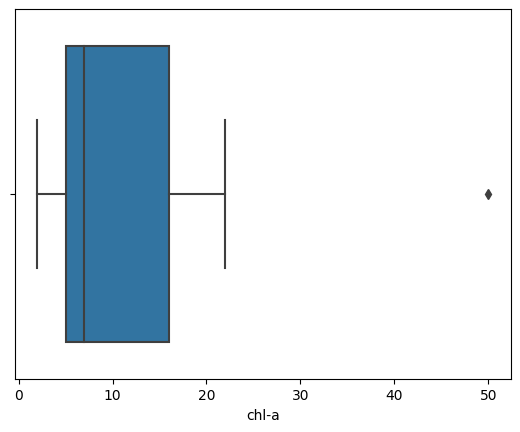

In [30]:
sns.boxplot(x=filtered['chl-a'])
plt.show()

In [31]:
filtered.sort_values('chl-a')['chl-a'].value_counts()

6.0     4
7.0     4
4.0     3
5.0     3
20.0    3
8.0     2
22.0    2
2.0     1
3.0     1
11.0    1
15.0    1
17.0    1
50.0    1
Name: chl-a, dtype: int64

Otro de los problemas de nuestro método es que algunas de las imágenes del MODIS-AQUA abarcan en gran porcentaje una región que no pertenece al lago, por lo que los valores de chl-a no son los que corresponden a nuestro estudio. Debemos ser cautelosos en este punto e intentar escoger aquel rango de valores de 'chl-a' que puedan asegurar cierta densidad de valores en un rango aceptable, es decir, que podamos tener cierta certeza de que esos valores corresponden a mediciones de dentro del lago. 

In [32]:
filtered = filtered[filtered['chl-a'] <= 8]

In [33]:
filtered.corr()['chl-a'].sort_values()

ndvi    -0.549105
gndvi   -0.504591
oc2     -0.079821
b8ab4   -0.007403
evi     -0.000493
b8b4     0.010731
b3b1     0.106945
b3b4     0.137257
b6b4     0.147221
oc4      0.163752
b5b4     0.178979
b3b2     0.200067
ndvi2    0.231461
b7b4     0.338807
mndwi    0.500079
ndwi     0.504591
nrvi     0.549105
chl-a    1.000000
Name: chl-a, dtype: float64

En este punto podemos observar la aparición de una correlación significativa entre los valores de ndvi, gndvi y chl-a, ambos índices espectrales teniendo una correlación negativa con los niveles de chl-a, que es lo que se obtuvo para el Lago Laja en Rodriguez-Lopez et al., 2011. 

In [34]:
filtered.shape

(18, 19)

# Limpieza de datos

In [35]:
def show_chla_corr(df):
    return df.corr()['chl-a'].sort_values(ascending=False)

In [36]:
filtered.describe()

,chl-a,mndwi,ndvi2,b5b4,b6b4,b7b4,b8ab4,b8b4,evi,nrvi,ndwi,gndvi,ndvi,b3b2,b3b4,oc2,b3b1,oc4
count,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,1.800000e+01,18.000000,18.000000
mean,5.555556,0.571495,0.175949,0.736235,0.787800,1.055436,0.927124,1.135980,0.019701,0.014371,0.494861,-0.494861,-0.014371,0.831965,6.355190,8.356235e+06,1.228931,2.065138
std,1.688098,0.288218,0.122880,0.207541,0.198052,0.227603,0.211770,0.380362,0.018998,0.049003,0.255643,0.255643,0.049003,0.106369,4.671582,3.520893e+07,0.736753,0.831426
min,2.000000,0.039765,0.007338,0.329104,0.379940,0.596383,0.590771,0.594471,-0.004804,-0.075528,0.031966,-0.766854,-0.149610,0.575071,0.657711,1.124144e+00,0.598508,1.277396
25%,4.250000,0.492734,0.098795,0.538325,0.624523,0.925085,0.769225,0.911016,0.006328,-0.004137,0.434302,-0.643313,-0.027180,0.789245,3.648361,1.660020e+00,0.892018,1.581219
50%,6.000000,0.674847,0.158777,0.820830,0.812939,1.108073,0.904459,1.042970,0.018546,0.012733,0.605532,-0.605532,-0.012733,0.858218,5.765979,1.771831e+00,0.953768,1.890046
75%,7.000000,0.772582,0.239040,0.877773,0.920148,1.203723,1.068574,1.248920,0.027348,0.027180,0.643313,-0.434302,0.004137,0.888062,8.657956,8.569186e+00,1.255116,2.169508
max,8.000000,0.865219,0.436280,0.982605,1.048313,1.436132,1.329549,2.137565,0.071593,0.149610,0.766854,-0.031966,0.075528,1.027753,18.584460,1.494333e+08,3.753858,4.795050


## chl-a

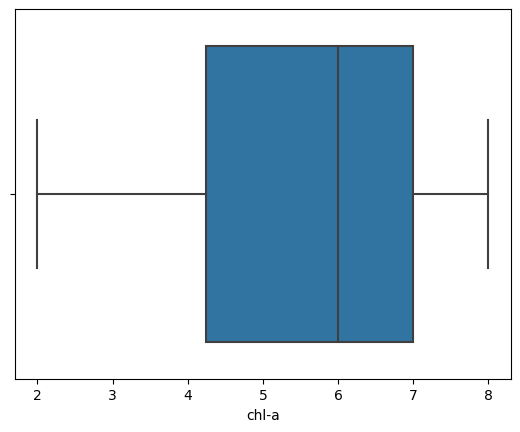

In [37]:
sns.boxplot(x=filtered['chl-a'])
plt.show()

## ndvi2

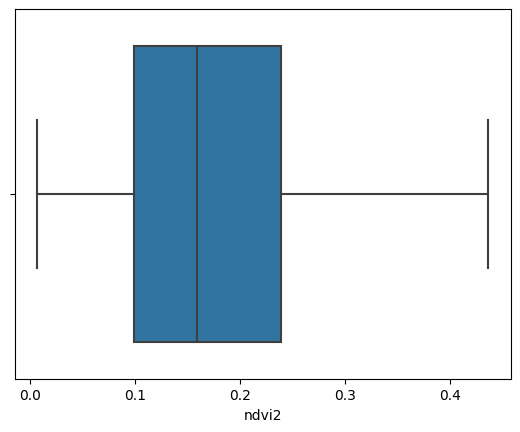

In [38]:
sns.boxplot(x=filtered['ndvi2'])
plt.show()

## b5b4

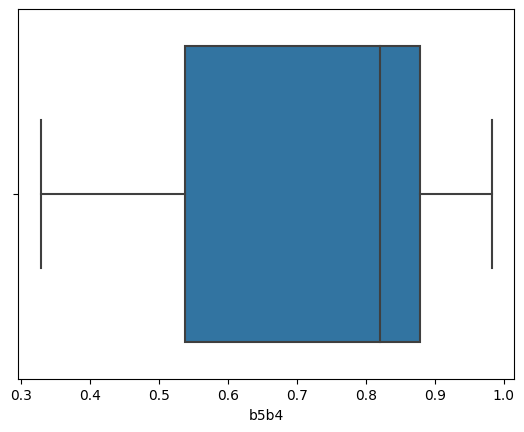

In [39]:
sns.boxplot(x=filtered['b5b4'])
plt.show()

## b6b4

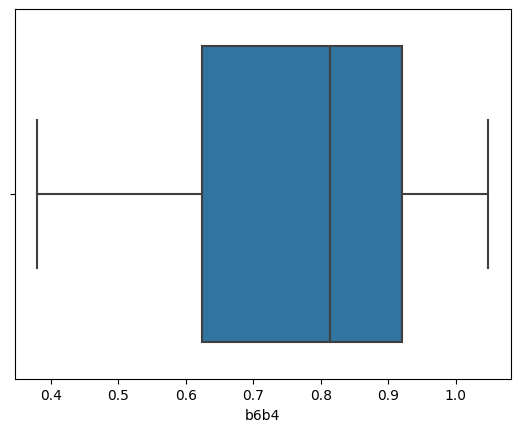

In [40]:
sns.boxplot(x=filtered['b6b4'])
plt.show()

## b7b4

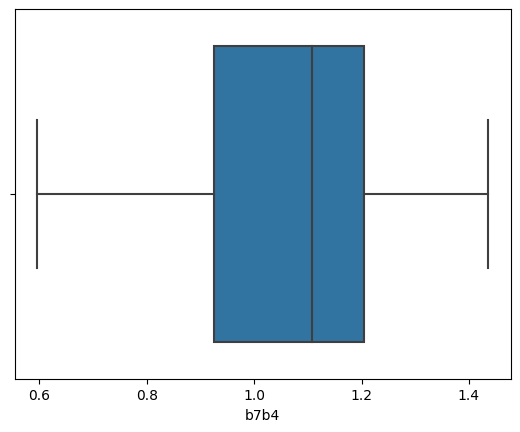

In [41]:
sns.boxplot(x=filtered['b7b4'])
plt.show()

## evi

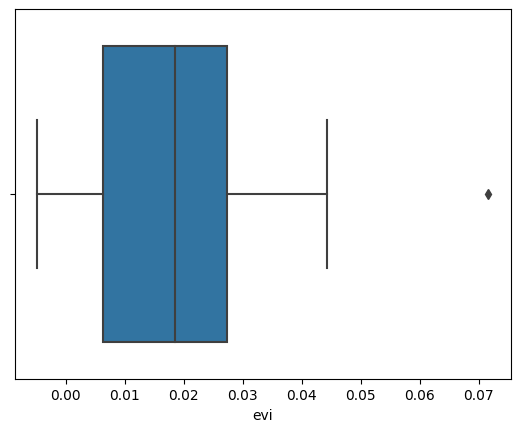

In [42]:
sns.boxplot(x=filtered['evi'])
plt.show()

## nrvi

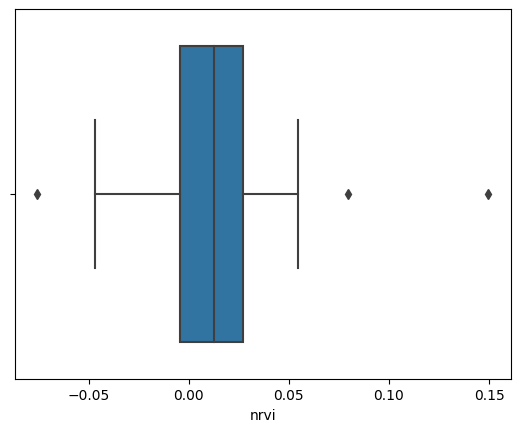

In [43]:
sns.boxplot(x=filtered['nrvi'])
plt.show()

## ndwi

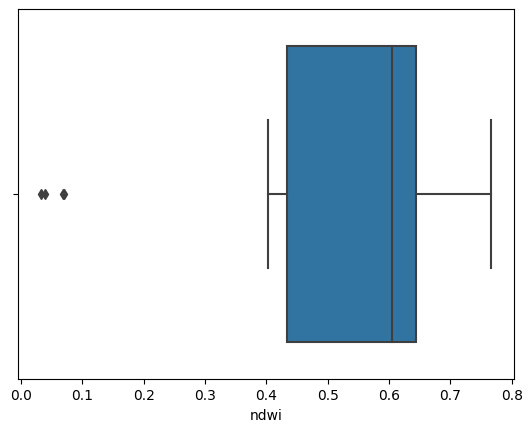

In [44]:
sns.boxplot(x=filtered['ndwi'])
plt.show()

## gndvi

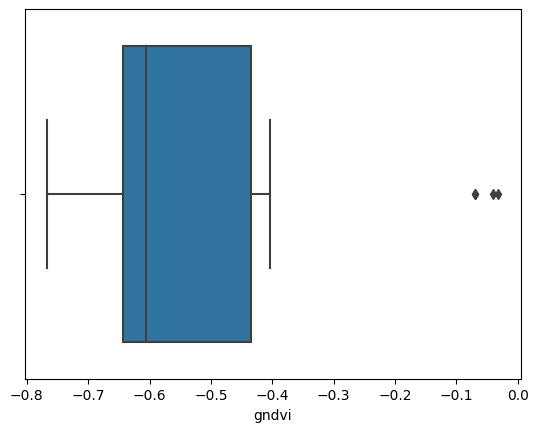

In [45]:
sns.boxplot(x=filtered['gndvi'])
plt.show()

## ndvi

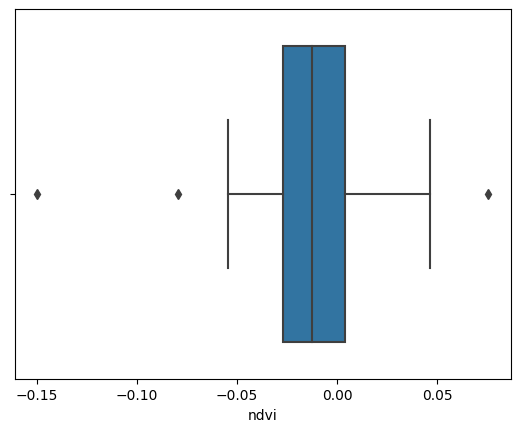

In [46]:
sns.boxplot(x=filtered['ndvi'])
plt.show()

## b3b2

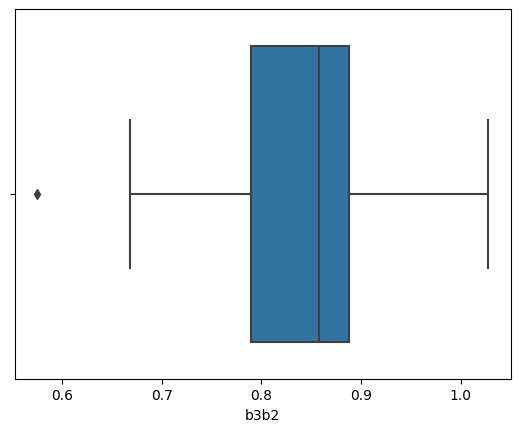

In [47]:
sns.boxplot(x=filtered['b3b2'])
plt.show()

## b3b4

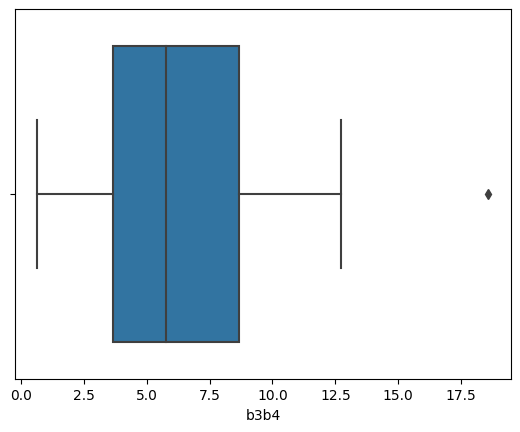

In [48]:
sns.boxplot(x=filtered['b3b4'])
plt.show()

## oc2

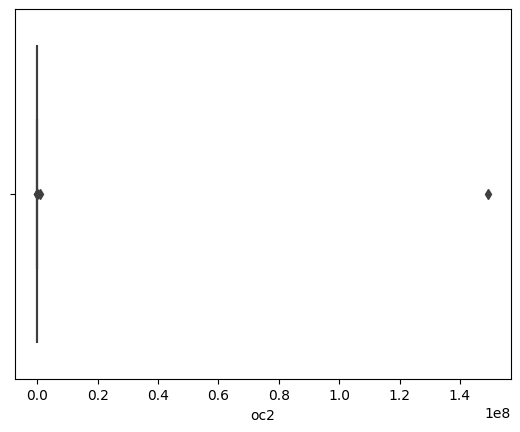

In [49]:
sns.boxplot(x=filtered['oc2'])
plt.show()

Aquí podemos observar claramente que tenemos un outlier. Lo identificaremos y volveremos a analizar estos datos.

In [50]:
filtered.sort_values('oc2', ascending=False).head()

,chl-a,mndwi,ndvi2,b5b4,b6b4,b7b4,b8ab4,b8b4,evi,nrvi,ndwi,gndvi,ndvi,b3b2,b3b4,oc2,b3b1,oc4,Fecha
24,5.0,0.448727,0.096275,0.329104,0.379940,0.709759,0.850422,1.457372,0.006353,-0.046570,0.403083,-0.403083,0.046570,0.733451,11.116432,1.494333e+08,1.338491,4.795050,2021-03-29
39,8.0,0.658494,0.112267,0.760107,1.048313,1.436132,1.329549,1.641819,0.044331,-0.005174,0.598591,-0.598591,0.005174,0.827798,12.716410,9.655887e+05,0.858720,3.272382,2019-02-25
37,6.0,0.657229,0.144860,0.874382,0.919462,1.168109,1.120252,1.113308,0.029586,0.016690,0.580648,-0.580648,-0.016690,0.862405,4.851316,1.035992e+04,0.834916,2.220127,2019-02-25
1,6.0,0.771170,0.352874,0.433791,0.582244,1.206311,1.029255,1.620836,0.024527,0.013162,0.646769,-0.646769,-0.013162,0.826720,9.414924,2.921403e+03,3.753858,1.908450,2020-03-26
6,2.0,0.639783,0.217688,0.519922,0.806683,1.135055,0.944892,1.162264,0.013103,-0.026146,0.562838,-0.562838,0.026146,0.668176,7.524148,1.067571e+01,1.199537,1.293463,2021-03-04


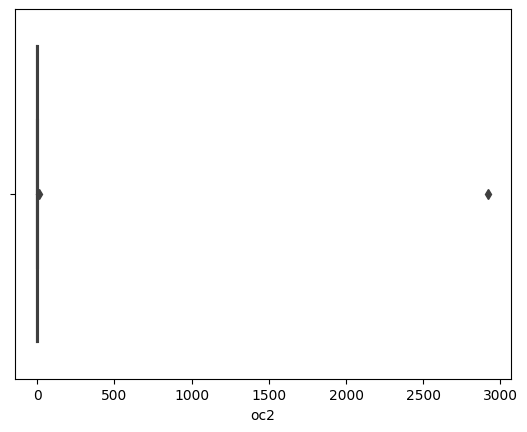

In [51]:
sns.boxplot(x=filtered[filtered['oc2'] <= 1.035992e+04]['oc2'])
plt.show()

Esta columna contiene a los menos 3 outliers, y dada la poca cantidad de registros que tenemos hemos preferido eliminar esta columna; el índice oc4 cumple un rol bastante similar al de oc2, por lo que la eliminación de este último no debería tener grandes impactos en nuestro método.

In [52]:
filtered.drop(columns=['oc2'], inplace=True)

In [53]:
filtered.corr()['chl-a'].sort_values(ascending=False)

chl-a    1.000000
nrvi     0.549105
ndwi     0.504591
mndwi    0.500079
b7b4     0.338807
ndvi2    0.231461
b3b2     0.200067
b5b4     0.178979
oc4      0.163752
b6b4     0.147221
b3b4     0.137257
b3b1     0.106945
b8b4     0.010731
evi     -0.000493
b8ab4   -0.007403
gndvi   -0.504591
ndvi    -0.549105
Name: chl-a, dtype: float64

## b3b1

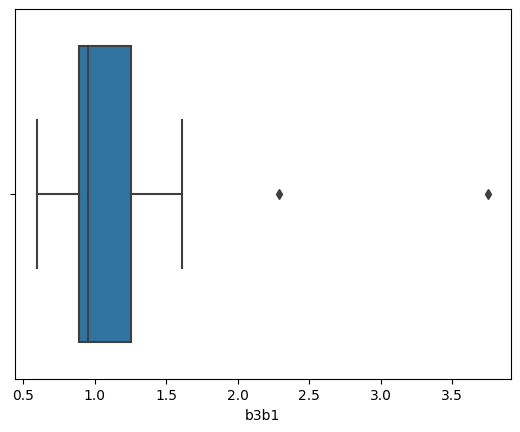

In [54]:
sns.boxplot(x=filtered['b3b1'])
plt.show()

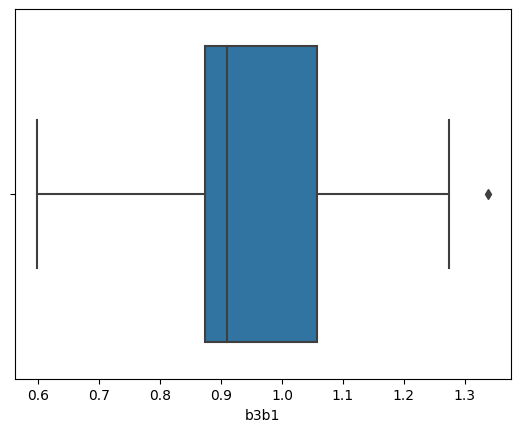

In [55]:
sns.boxplot(x=filtered[filtered['b3b1'] < 1.5]['b3b1'])
plt.show()

## oc4

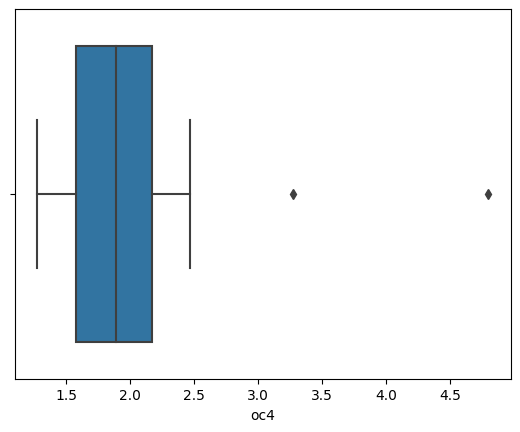

In [56]:
sns.boxplot(x=filtered['oc4'])
plt.show()

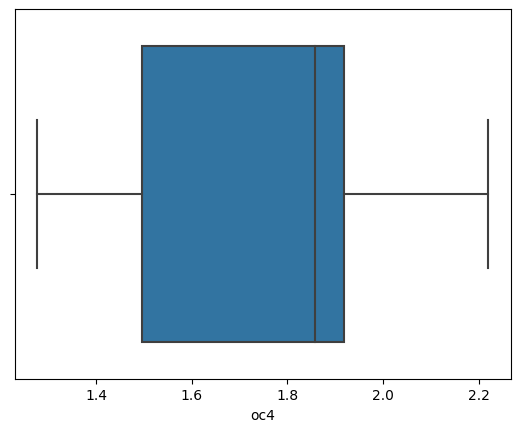

In [57]:
sns.boxplot(x=filtered[filtered['oc4'] < 2.3]['oc4'])
plt.show()

In [58]:
filtered = filtered[filtered['oc4'] < 2.3]

## mndwi

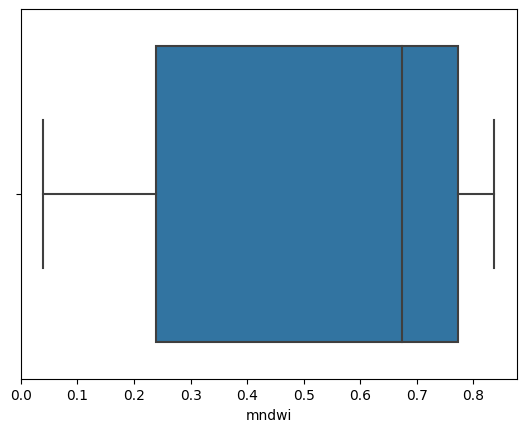

In [59]:
sns.boxplot(x=filtered['mndwi'])
plt.show()

In [60]:
show_chla_corr(filtered)

chl-a    1.000000
nrvi     0.601583
ndwi     0.588204
mndwi    0.586046
b3b4     0.363737
ndvi2    0.352906
b3b2     0.342109
oc4      0.334082
b7b4     0.278253
b3b1     0.218434
b8b4     0.148625
b5b4     0.079854
b8ab4   -0.050671
b6b4    -0.096408
evi     -0.266725
gndvi   -0.588204
ndvi    -0.601583
Name: chl-a, dtype: float64

In [65]:
filtered.corr()[['chl-a']].abs().sort_values(by='chl-a', ascending=False).T

,chl-a,nrvi,ndvi,gndvi,ndwi,mndwi,b3b4,ndvi2,b3b2,oc4,b7b4,evi,b3b1,b8b4,b6b4,b5b4,b8ab4
chl-a,1.0,0.601583,0.601583,0.588204,0.588204,0.586046,0.363737,0.352906,0.342109,0.334082,0.278253,0.266725,0.218434,0.148625,0.096408,0.079854,0.050671


Podemos observar que con la limpieza de datos ha aumentado la correlación que gndvi y ndvi tenían con chl-a originalmente. Índices como el oc4 y b3b2 de los cuales se esperaba una alta correlación por los estudios de Bravo Herrera J., 2021, no muestran una correlación significativa con los niveles de chl-a.

In [66]:
filtered = filtered.sort_values('Fecha').reset_index(drop=True)
filtered.head()

,chl-a,mndwi,ndvi2,b5b4,b6b4,b7b4,b8ab4,b8b4,evi,nrvi,ndwi,gndvi,ndvi,b3b2,b3b4,b3b1,oc4,Fecha
0,6.0,0.657229,0.144860,0.874382,0.919462,1.168109,1.120252,1.113308,0.029586,0.016690,0.580648,-0.580648,-0.016690,0.862405,4.851316,0.834916,2.220127,2019-02-25
1,7.0,0.790962,0.172410,0.878903,0.892516,1.223973,1.081681,1.230580,0.012210,0.040060,0.710203,-0.710203,-0.040060,0.924838,8.984333,0.927533,2.017650,2019-02-25
2,5.0,0.837138,0.331099,0.973911,1.034935,1.369906,1.164169,1.255033,-0.002424,-0.023158,0.718187,-0.718187,0.023158,0.923287,7.678824,0.887467,1.622199,2019-02-25
3,6.0,0.691201,0.195097,0.796532,0.819195,1.081090,0.939600,0.980891,0.006320,0.021279,0.612473,-0.612473,-0.021279,0.867631,5.642674,0.909991,1.997487,2019-02-25
4,6.0,0.771170,0.352874,0.433791,0.582244,1.206311,1.029255,1.620836,0.024527,0.013162,0.646769,-0.646769,-0.013162,0.826720,9.414924,3.753858,1.908450,2020-03-26


In [67]:
xcols = ['oc4', 'b3b2']

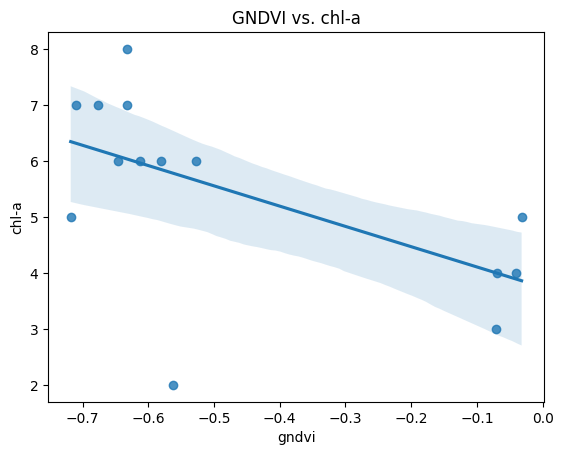

In [68]:
fig, ax = plt.subplots(1)
ax.set_title('GNDVI vs. chl-a')
sns.regplot(x=filtered['gndvi'], y=filtered['chl-a'], ax=ax)
plt.show()

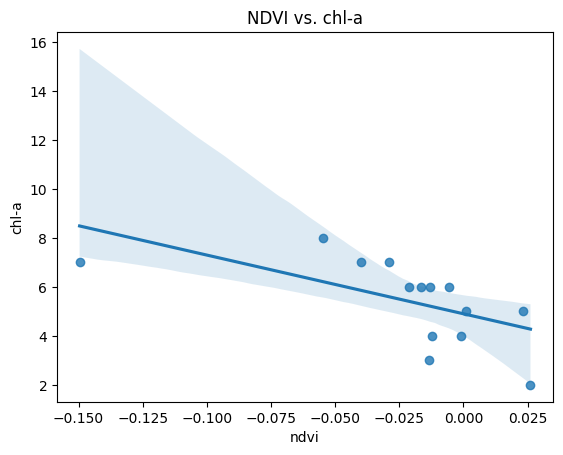

In [69]:
fig, ax = plt.subplots(1)
ax.set_title('NDVI vs. chl-a')
sns.regplot(x=filtered['ndvi'], y=filtered['chl-a'], ax=ax)
plt.show()

In [70]:
filtered.corr()[['chl-a']].loc[['ndvi', 'gndvi', 'b3b2', 'oc4'], :].T

,ndvi,gndvi,b3b2,oc4
chl-a,-0.601583,-0.588204,0.342109,0.334082


In [71]:
X = filtered[['gndvi', 'ndvi']].values
y = filtered['chl-a'].values
y.shape = (len(y), 1)

In [72]:
ls = spreg.ols.OLS(y, X, name_y='chl-a', name_x=['gndvi', 'ndvi'])
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :       chl-a                Number of Observations:          14
Mean dependent var  :      5.4286                Number of Variables   :           3
S.D. dependent var  :      1.6968                Degrees of Freedom    :          11
R-squared           :      0.5474
Adjusted R-squared  :      0.4651
Sum squared residual:      16.942                F-statistic           :      6.6508
Sigma-square        :       1.540                Prob(F-statistic)     :     0.01278
S.E. of regression  :       1.241                Log likelihood        :     -21.200
Sigma-square ML     :       1.210                Akaike info criterion :      48.401
S.E of regression ML:      1.1001                Schwarz criterion     :      50.318

-----------------------------------------------------------------------------

In [574]:
ls.betas

array([[  3.80031847],
       [ -2.92434416],
       [-18.09906669]])

Si bien los resultados de la regresión no son los mejores, si parece ser una posibilidad para la estimación de los niveles de chl-a. Dada la poca cantidad de datos que tenemos a nuestra disposición, no parace viable hacer validación basada en estos datos. Una posible mejora a este método es la utilización de algún satélite que tenga una disponibilidad histórica mayor a Sentinel 2. 

Ahora, procederemos a utilizar el modelo obtenido para obtener una predicción de los niveles de chl-a basada en los índices espectrales de gndvi y ndvi. Esta predicción tendrá una resolución de 10m.

In [73]:
def calculate_chla(collection_images):
    chla_collection = collection_images.map(lambda image: image.expression(
        '3.72 -2.77 * gndvi -18.69 * ndvi',
        {
            'gndvi': calculate_gndvi_image(image),
            'ndvi': calculate_ndvi_image(image)
        }
    ))
    return chla_collection


def calculate_gndvi_image(image):
    gndvi = image.expression(
        '(NIR - GREEN) / (NIR + GREEN)',
        {
            'NIR': image.select('B8'),
            'GREEN': image.select('B3')
        }
    )
    return gndvi
    
def calculate_ndvi_image(image):
    ndvi = image.expression(
        '(NIR - RED) / (NIR + RED)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4')
        }
    )
    return ndvi



Como fecha clave, escogeremos el día 3 de mayo del 2023, ya que para ese día se cuenta con una imagen de alta calidad publicada por la NASA de la vista de un bloom de algas desde el espacio. También se cuenta con otra imagen comparativa realizada por un especializado del área. Más detalles en el informe.

In [74]:
fecha = '2023-05-03'

dayOfInterest = ee.Date(fecha)

sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR')\
.filterDate(dayOfInterest, dayOfInterest.advance(1, 'day'))\
.filterBounds(aoi)

In [75]:
calculate_chla_image = calculate_chla(sentinel2_collection).first()
calculate_chla_image

In [76]:
centroide_villarrica = aoi.centroid().getInfo()['coordinates']
centroide_villarrica.reverse()

In [77]:
# Parámetros de visualización
visParams = {
    'min': 0,
    'max': 5,
    'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']   
}

# Visualización de la imagen
Map = geemap.Map(location = centroide_villarrica, zoom = 10)
Map.addLayer(calculate_chla_image, visParams, 'CHL-A')
# Map.addLayer(aoi, {}, 'AOI')
Map.add_colorbar(visParams, label="CHL-A")
Map

Map(center=[-39.25195733326285, -72.09914326222655], controls=(WidgetControl(options=['position', 'transparent…

REMINDER: CORRER LA VISUALIZACION DE ARRIBA PARA PODER COMPARAR.

![](https://eoimages.gsfc.nasa.gov/images/imagerecords/151000/151363/lakevillarrica_oli_2023123_lrg.jpg)


Algunas cosas que podemos observar:

- El modelo parece captar bien la estructura y dinámica del fenómeno de bloom de algas! Un resultado bastante esperanzador, tomando en cuenta que la relación entre los índices espectrales utilizados y los niveles de chl-a no es trivial.

- El modelo tiende a sobreestimar los valores de chl-a. Tiene un valor base que no parece ser representativo de la realidad. Sin embargo, sí parece ser capaz de captar los incrementos sobre un nivel normal de chl-a.


A continuación se presenta un timelapse la aproximación los niveles de chl-a de nuestro modelo para el bloom de algas registrado en el Lago Villarica en Enero del 2023. Notar que se considera desde un periodo de tiempo anterior y hasta un periodo de tiempo posterior, para poder observar bien la evolución del fenómeno.

In [94]:
bloom_enero = get_sentinel2_collection('2022-12-15', '2023-02-15', aoi).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
chla_bloom_enero = calculate_chla(bloom_enero)
videoArgs = {'dimensions': 768,
             'region': aoi,
             'framesPerSecond': 2,
             'crs': 'EPSG:32719',
             'min': 0,
             'max': 5,
             'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}


print(chla_bloom_enero.getVideoThumbURL(videoArgs));

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/videoThumbnails/75ad79660313c6ec6c03ab3dcb4fe418-cffce0e2a9db90c26b8ea89bab3dd6e5:getPixels


![](https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/videoThumbnails/75ad79660313c6ec6c03ab3dcb4fe418-cffce0e2a9db90c26b8ea89bab3dd6e5:getPixels)

Se nota que el método es capaz de captar los incrementos en los niveles de chl-a. Veamos ahora la aproximación del modelo para el blooms de algas en Mayo de 2023.

In [95]:
bloom_mayo = get_sentinel2_collection('2023-04-01', '2023-05-30', aoi).filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 20)
chla_bloom_mayo = calculate_chla(bloom_mayo)
videoArgs = {'dimensions': 768,
             'region': aoi,
             'framesPerSecond': 2,
             'crs': 'EPSG:32719',
             'min': 0,
             'max': 5,
             'palette': ['black', 'blue', 'purple', 'cyan', 'green', 'yellow', 'red']}


print(chla_bloom_mayo.getVideoThumbURL(videoArgs));

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/videoThumbnails/801f6e0454e2be0842bc691cb2473efa-501044d360331fc598fcd3c76be778e4:getPixels


![](https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/videoThumbnails/801f6e0454e2be0842bc691cb2473efa-501044d360331fc598fcd3c76be778e4:getPixels)

En ambos casos, antes del fenómeno se puede observar un color verde parejo indicativo del valor base que capta nuestro método. Cuando ocurre el fenómeno de bloom de algas, nuestro método es capaz de identificar tanto la estructura como la dinámica de este fenómeno, aunque se desconoce la precisión con que los valores de chl-a son aproximados. 